In [1]:
import pathlib

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from sequence_transformations import TransformationHuffman, TransformationRefined, TransformationRudimentary

In [2]:
def read_dna_data_from_file(file_path: str) -> tuple[list[str], list[int]]:
    sequences: list[str] = []
    classes: list[int] = []

    with open(file_path, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            seq_str: str = str(record.seq)
            # The class is the last character in the sequence
            class_label: int = int(seq_str[-1])
            dna_sequence: str = seq_str[:-1]

            sequences.append(dna_sequence)
            classes.append(class_label)

    return sequences, classes

In [3]:
sequences, classes = [], []

for file_path in pathlib.Path("../data/classification").glob("*.txt"):
    file_sequences, file_classes = read_dna_data_from_file(file_path)

    sequences.extend(file_sequences)
    classes.extend(file_classes)

In [4]:
df = pd.DataFrame({"sequences": sequences, "classes": classes})

In [5]:
df.head()

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
3,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
4,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0


In [6]:
df["sequences"].map(len).describe()

count    287367.000000
mean        499.970894
std           2.315009
min         290.000000
25%         500.000000
50%         500.000000
75%         500.000000
max         500.000000
Name: sequences, dtype: float64

In [7]:
sequences_len_diff_500 = df[df["sequences"].map(len) != 500]

In [8]:
sequences_len_diff_500.head(2)

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
263,TTATATTTGTTTAAATTGGATTTGTTTACATTAGATTTGTTTACAT...,0


<Axes: xlabel='classes', ylabel='count'>

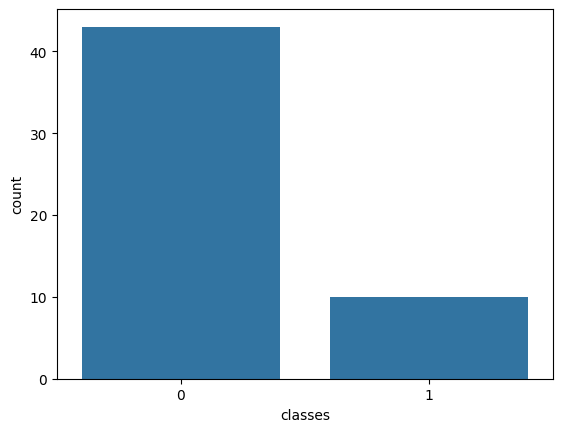

In [9]:
sns.countplot(x=sequences_len_diff_500["classes"])

We will drop the sequences with length different from 500

In [10]:
df.shape

(287367, 2)

In [11]:
len(sequences_len_diff_500.index)

53

In [12]:
df.drop(sequences_len_diff_500.index, inplace=True)

In [13]:
(df["sequences"].map(len) != 500).sum()

0

The distribution of the labels

<Axes: xlabel='classes', ylabel='count'>

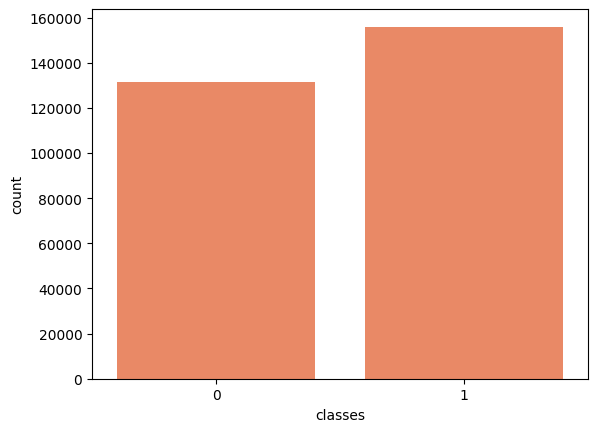

In [14]:
sns.countplot(x=df["classes"], color="coral")

In [ ]:
sampled_df = df.groupby("classes", group_keys=False).apply(
    lambda x: x.sample(100, random_state=312)
)

In [24]:
# Rudimentary
rudimentary_df_sample = sampled_df.copy()
rudimentary_df_sample["sequences"] = rudimentary_df_sample["sequences"].map(
    TransformationRudimentary().transform
)

# Refined
refined_df_sample = sampled_df.copy()
refined_df_sample["sequences"] = refined_df_sample["sequences"].map(
    TransformationRefined().transform
)

# HUffman
def transform_sequence_huffman(x: str) -> pd.Series:
    return TransformationHuffman(x).transform(x)

huffman_df_sample = sampled_df.copy()
huffman_df_sample["sequences"] = huffman_df_sample["sequences"].map(
    transform_sequence_huffman
)

In [25]:
CLASS_COLORS = {0: "orange", 1: "green"}


def plot_sequence(row, ax):
    sequence = row["sequences"]
    class_label = row["classes"]
    x, y = zip(*sequence)
    color = CLASS_COLORS[class_label]
    ax.plot(x, y, color=color, linestyle="-", marker="o", markersize=0.7)


def create_legend_handle(class_label):
    color = CLASS_COLORS[class_label]
    return mlines.Line2D(
        [],
        [],
        color=color,
        marker="o",
        linestyle="None",
        markersize=10,
        label=f"Class {class_label}",
    )

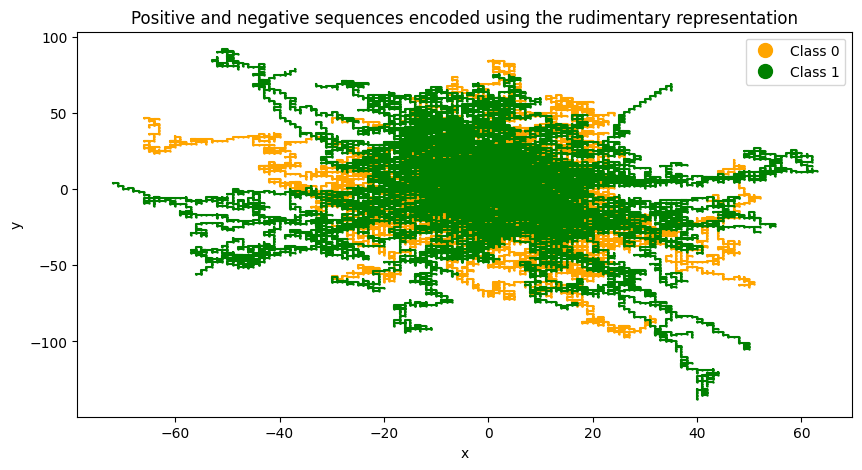

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("x")
ax.set_ylabel("y")

for index, row in rudimentary_df_sample.iterrows():
    plot_sequence(row, ax)

legend_handles = [create_legend_handle(label) for label in CLASS_COLORS.keys()]
ax.legend(handles=legend_handles)

plt.title("Positive and negative sequences encoded using the rudimentary representation")
plt.show()

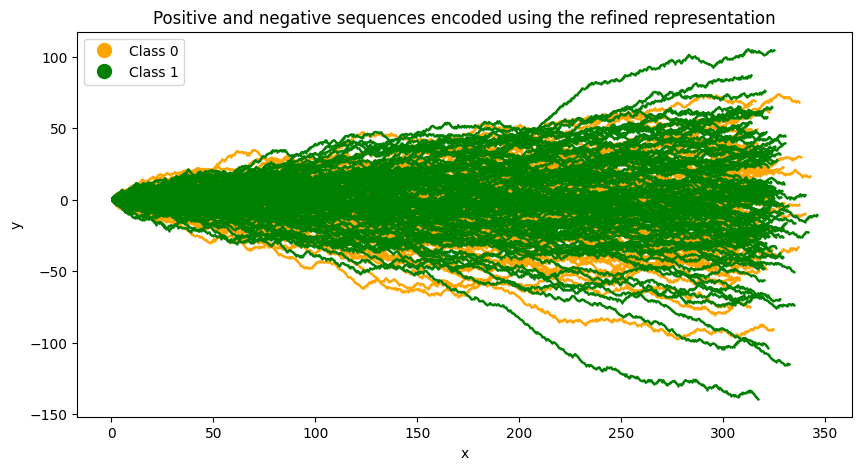

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("x")
ax.set_ylabel("y")

for index, row in refined_df_sample.iterrows():
    plot_sequence(row, ax)

legend_handles = [create_legend_handle(label) for label in CLASS_COLORS.keys()]
ax.legend(handles=legend_handles)

plt.title("Positive and negative sequences encoded using the refined representation")
plt.show()

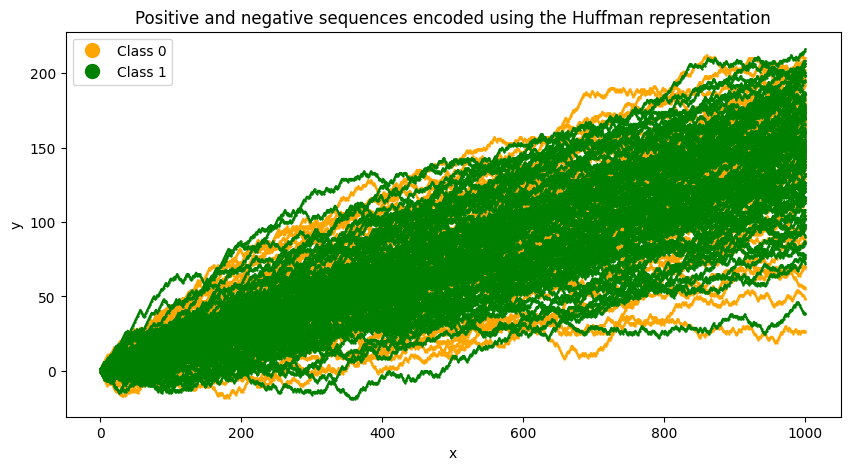

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("x")
ax.set_ylabel("y")

for index, row in huffman_df_sample.iterrows():
    plot_sequence(row, ax)

legend_handles = [create_legend_handle(label) for label in CLASS_COLORS.keys()]
ax.legend(handles=legend_handles)

plt.title("Positive and negative sequences encoded using the Huffman representation")
plt.show()

In [29]:
df.to_csv("../data/classification/data.csv", index=False)